# Word2Vec

このノートで使うパッケージをimportしておきましょう．

In [1]:
# packageのimport
from typing import Any, Union, Callable, Type, TypeVar
from tqdm.auto import trange,tqdm
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

c:\Users\ramen\class-1\class-1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pytorch関連のモジュールをimportしておきましょう．

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## 単語のベクトル表現

### 離散表現と分散表現

単語をベクトルとして表現する方法として古くから使われているのがone-hot表現です．これはある要素のみが1でそれ以外が0であるような表現のことであり，単語に対応したベクトルのある要素のみが1でそれ以外が0であるようなベクトルを用いることで，単語をベクトル表現します．

> ![](https://jiho-ml.com/content/images/2020/04/figure1-4.png)  
one-hot表現のイメージ  
出典: [위클리 NLP Week 2 - 단어를 가방에 때려 넣으면 문장이 된다](https://jiho-ml.com/weekly-nlp-2/)

one-hotベクトルはシンプルなアイディアで理解しやすいですが，語彙の数だけベクトルの次元数が必要になることに注意が必要です．また，「オートバイ」と「バイク」のようなほぼほぼ似たような意味の単語同士の類似度をcosine類似度で計算しようとしても，それぞれが別の次元が立っているだけのベクトルなので内積0となってしまい，意味的な類似度を測ることには適さないことがわかります．

ここではこのone-hot表現を離散表現の例として紹介しました．

また，文書中に登場した単語のone-hotベクトルを足し合わせることで，文書をベクトル表現するBag-of-Words（BoW）という表現方法もあります．
> ![](https://jiho-ml.com/content/images/2020/04/figure2-3.png)  
BoWのイメージ  
出典: [위클리 NLP Week 2 - 단어를 가방에 때려 넣으면 문장이 된다](https://jiho-ml.com/weekly-nlp-2/)




この場合はただ足し合わせるだけなので，文書中に同じ単語が何回か登場したら，1以上の整数がベクトル内に現れることもあります．
> ![](https://jiho-ml.com/content/images/2020/05/bow.JPEG)  
BoWのイメージ2   
出典: [위클리 NLP Week 2 - 단어를 가방에 때려 넣으면 문장이 된다](https://jiho-ml.com/weekly-nlp-2/)




#### 課題1

語彙idと語彙数が与えられたときに，one-hotベクトルを作成する関数を作成せよ．
また，作成した関数を使って以下を実行せよ．

```python
print(build_onehot(1, 5))
print(build_onehot(10, 20))
print(build_onehot(0, 6))
```

In [3]:
def build_onehot(id,vocab_size:int):

  onehot = np.zeros(vocab_size)
  onehot[id ] = 1
  return onehot


In [4]:
print(build_onehot(1, 5))
print(build_onehot(10, 20))
print(build_onehot(0, 6))

[0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0.]


#### 課題2

語彙idのリストと語彙数が与えられた時に，bowベクトルを作成する関数を作成せよ．また，作成した関数を使って以下を実行せよ．

```python
print(build_bow([0,0,3,1], 5))
```

In [5]:
def build_bow(id_list:list,vocab_size:int):
  bow = np.zeros(vocab_size)
  for i in id_list:
    bow[i] += 1

  return bow

In [6]:
print(build_bow([0,0,3,1], 5))

[2. 1. 0. 1. 0.]


### 様々な分散表現

one-hot表現に対して，分散表現とは単語を語彙数に比べて低次元の実数値ベクトルで表す表現です．多くの場合50~300次元が用いられています．これの利点としては，
- 語彙数に左右されずにベクトルの次元数を決定できるため計算量を抑えられる
- 同じような意味の単語に同じようなベクトル表現を当てがうことができるのならば，cosine類似度のような簡単な計算で意味の類似度（のようなもの）を評価することができる

などが考えられます．現代の自然言語処理においても，このアプローチが取られることが多いです．

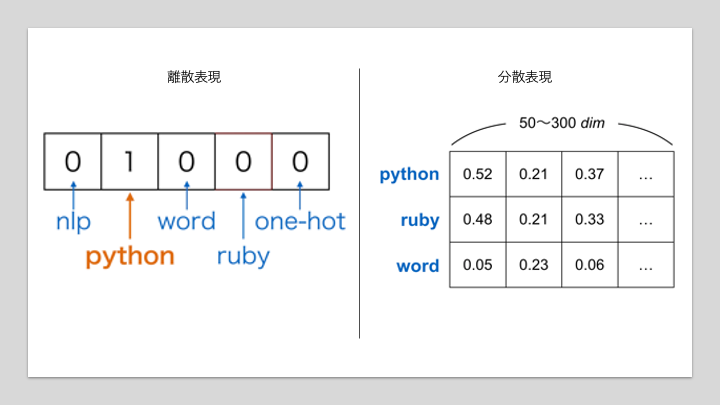
離散表現と分散表現  
出典: [なぜ自然言語処理にとって単語の分散表現は重要なのか？](https://qiita.com/Hironsan/items/a58636f946dd51f670b0)

この分散表現の作り方には色々な方法があります．例えばBoWで表現された文章データをNMF（Non-Negative Matrix Factorization, 非負値行列因子分解）やLSA（Latent Semantic Analysis, 潜在的意味解析）のような手法で行列分解することで作成することもできます．ただし作成できるベクトルが持つ意味（作成されたベクトルがどのような使い方に適したものなのか）は手法により様々です．今回は，ニューラルネットワークを用いて単語の分散表現が作れるword2vecと呼ばれる手法群の中でも，CBOWについて紹介します．

## Continuous Bag-of-Words

### CBOWと分布仮説

> word2vec はある単語から周囲の単語を予測するタスクを解くことで，各単語の低次元（数百次元）の分散表現を獲得する手法です．この手法は，分布仮説「単語の意味は周囲の単語との関係性から規定される」に基づいて次元削減で低次のベクトル表現を獲得することある条件下において同等であると証明されています．分布仮説において，例えば，「ラーメン」と「うどん」はそれぞれ，「食べる」や「昼飯」や「麺」などの同じ単語と共起しやすいため，この二つの単語は近いと考えられます．  
　自然言語における分布仮説は，ネットワーク分析における「ある人を知りたければその友人を見よ」や「論文の内容はその引用関係から推定できる」という考え方と類似しています．  
> 引用: [Vol.31.No.4(2016/7)ネットワークの表現学習 -- 人工知能学会](https://www.ai-gakkai.or.jp/resource/my-bookmark/my-bookmark_vol31-no4/#:~:text=%E8%87%AA%E7%84%B6%E8%A8%80%E8%AA%9E%E3%81%AB%E3%81%8A%E3%81%91%E3%82%8B%E5%88%86%E5%B8%83%E4%BB%AE%E8%AA%AC%E3%81%AF%EF%BC%8C%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E5%88%86%E6%9E%90%E3%81%AB%E3%81%8A%E3%81%91%E3%82%8B%E3%80%8C%E3%81%82%E3%82%8B%E4%BA%BA%E3%82%92%E7%9F%A5%E3%82%8A%E3%81%9F%E3%81%91%E3%82%8C%E3%81%B0%E3%81%9D%E3%81%AE%E5%8F%8B%E4%BA%BA%E3%82%92%E8%A6%8B%E3%82%88%E3%80%8D%E3%82%84%E3%80%8C%E8%AB%96%E6%96%87%E3%81%AE%E5%86%85%E5%AE%B9%E3%81%AF%E3%81%9D%E3%81%AE%E5%BC%95%E7%94%A8%E9%96%A2%E4%BF%82%E3%81%8B%E3%82%89%E6%8E%A8%E5%AE%9A%E3%81%A7%E3%81%8D%E3%82%8B%E3%80%8D%E3%81%A8%E3%81%84%E3%81%86%E8%80%83%E3%81%88%E6%96%B9%E3%81%A8%E9%A1%9E%E4%BC%BC%E3%81%97%E3%81%A6%E3%81%84%E3%81%BE%E3%81%99%EF%BC%8E%E3%81%93%E3%81%AE%E3%82%88%E3%81%86%E3%81%AB%EF%BC%8C%E5%88%86%E5%B8%83%E4%BB%AE%E8%AA%AC%E3%81%AB%E5%9F%BA%E3%81%A5%E3%81%84%E3%81%9F%E8%87%AA%E7%84%B6%E8%A8%80%E8%AA%9E%E5%87%A6%E7%90%86%E3%81%A8%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E5%88%86%E6%9E%90%E3%81%AF%EF%BC%8C%E5%91%A8%E5%9B%B2%E3%81%AE%E9%96%A2%E4%BF%82%E6%80%A7%E3%81%8B%E3%82%89%E8%A6%81%E7%B4%A0%E3%81%AE%E6%80%A7%E8%B3%AA%E3%82%92%E6%8E%A8%E5%AE%9A%E3%81%99%E3%82%8B%E3%81%A8%E3%81%84%E3%81%86%E6%84%8F%E5%91%B3%E3%81%A7%E8%BF%91%E3%81%84%E3%81%A8%E3%81%84%E3%81%88%E3%81%BE%E3%81%99%EF%BC%8E2014%20%E5%B9%B4%E3%81%AB%E7%99%BA%E8%A1%A8%E3%81%95%E3%82%8C%E3%81%9FDeepWalk%20%E3%81%AF%EF%BC%8C%E3%81%93%E3%81%AE%E8%80%83%E3%81%88%E6%96%B9%E3%82%92%E3%82%82%E3%81%A8%E3%81%ABword2vec,%E3%82%92%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E6%A7%8B%E9%80%A0%E3%81%AE%E8%A1%A8%E7%8F%BE%E5%AD%A6%E7%BF%92%E3%81%AB%E5%BF%9C%E7%94%A8%E3%81%97%E3%81%9F%E6%89%8B%E6%B3%95%E3%81%A7%E3%81%99%EF%BC%8EDeepWalk%20%E3%81%A7%E3%81%AF%EF%BC%8C%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E3%81%AE%E3%83%AA%E3%83%B3%E3%82%AF%E4%B8%8A%E3%82%92%E3%83%A9%E3%83%B3%E3%83%80%E3%83%A0%E3%82%A6%E3%82%A9%E3%83%BC%E3%82%AF%E3%81%99%E3%82%8B%E3%81%93%E3%81%A8%E3%81%AB%E3%82%88%E3%81%A3%E3%81%A6%E8%BE%BF%E3%82%8C%E3%82%8B%E3%83%8E%E3%83%BC%E3%83%89%E3%81%AE%E5%88%97%E3%82%92%E2%80%9D%E6%96%87%E8%84%88%E2%80%9D%E3%81%A8%E3%81%BF%E3%81%AA%E3%81%97%EF%BC%8C%E3%81%9D%E3%81%AE%E6%96%87%E8%84%88%E3%82%92word2vec%20%E3%81%AB%E3%82%A4%E3%83%B3%E3%83%97%E3%83%83%E3%83%88%E3%81%97%E3%81%A6%E3%83%8E%E3%83%BC%E3%83%89%E3%81%AE%E5%88%86%E6%95%A3%E8%A1%A8%E7%8F%BE%E3%82%92%E8%A8%88%E7%AE%97%E3%81%97%E3%81%BE%E3%81%99%EF%BC%8E)

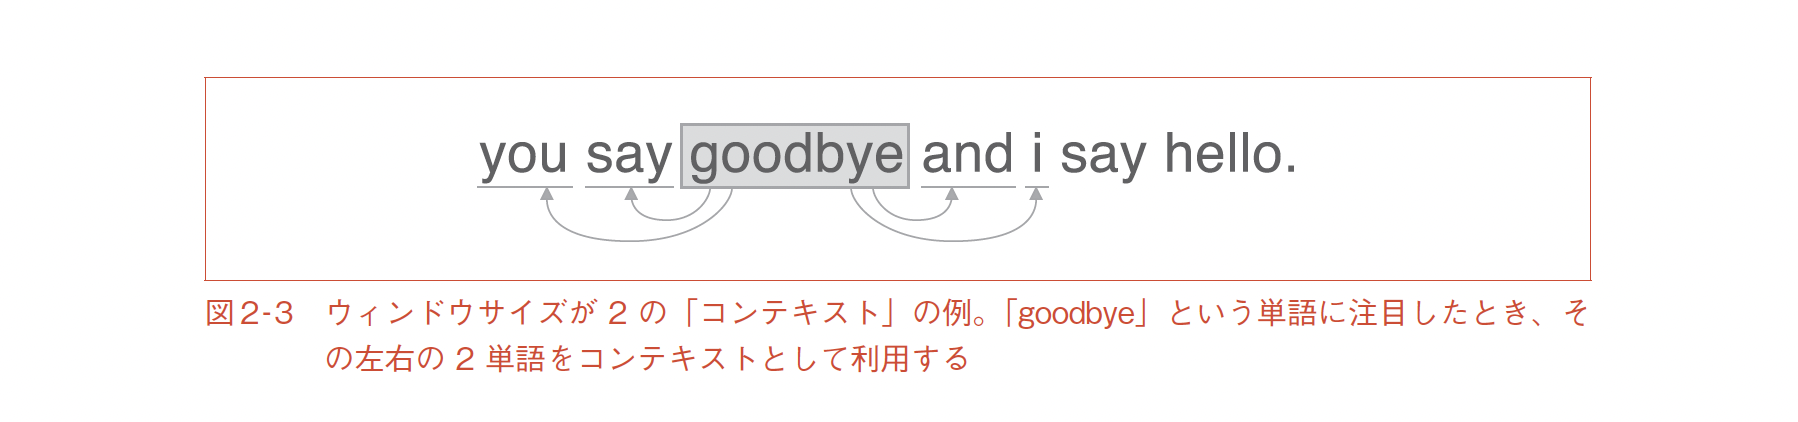
説明したい単語「goodbye」と，その周辺にあってこの単語の意味を推測するのに使えそうな単語達（コンテキスト）の関係．  
出典: [ゼロから作るDeep Learning 2 自然言語処理編](https://www.oreilly.co.jp/books/9784873118369/)

この分布仮説をもとに，ニューラルネットワークを使って単語の意味をある程度表現できるようなベクトル表現を獲得できる手法がこれから紹介するCBOWです．

### CBOWのアーキテクチャ

CBoWでは，周辺の単語を入力にして目的の単語を予測するネットワークを構築します．

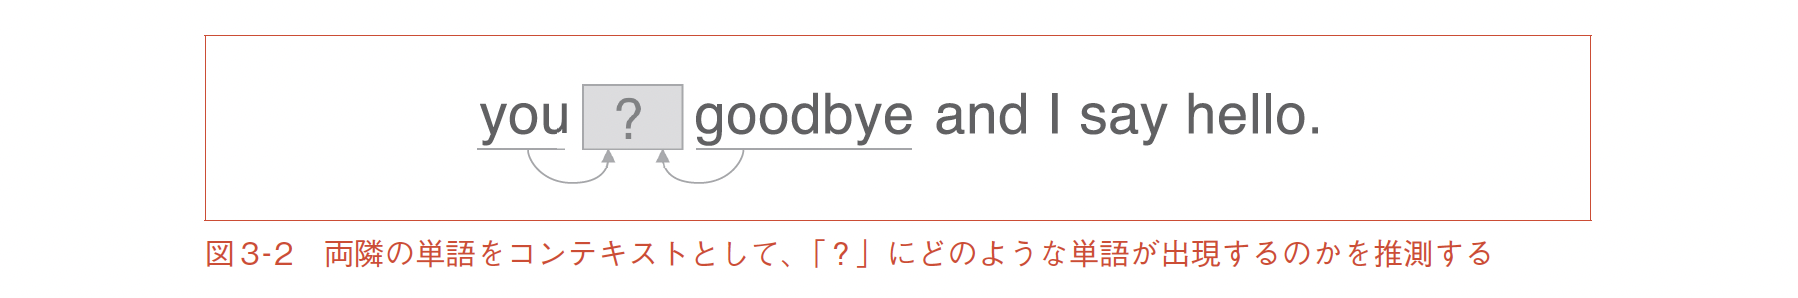
コンテキストを使った単語の予測．  
出典: [ゼロから作るDeep Learning 2 自然言語処理編](https://www.oreilly.co.jp/books/9784873118369/)

CBOWは単純なMLPを利用して，語彙数$V$，埋め込み次元数$N$の場合に，全ての語彙それぞれに対応する単語埋め込みベクトルの束である$\mathbf{W}_{V, N}$を作成します．



> ![Illustration of the word2vec models: (a) CBOW, (b) skip-gram [16, 33]. ](https://www.researchgate.net/profile/Elena-Tutubalina/publication/318507923/figure/fig2/AS:613947946319904@1523388005889/Illustration-of-the-word2vec-models-a-CBOW-b-skip-gram-16-33.png)  
word2vecのアーキテクチャ．左側がCBoW，また右側はSkip-Gram．   
出典: [Demographic Prediction Based on User Reviews about Medications](https://www.scielo.org.mx/pdf/cys/v21n2/1405-5546-cys-21-02-00227.pdf)

### 実装

クラスの実装上で明確に異なるのはMLPの最初のLinear層の前に，Embeddingレイヤーと便宜上名付けられた層が追加されていることです．

Embeddingレイヤはこのモデルで扱いたい語彙（異なり語，ユニークな単語）の数$V$（コード中では `vocab_size`）のベクトルを持っており，入力された語彙に対応したベクトルを取り出して返します．この語彙に対応したベクトルを __単語埋め込みベクトル__ と呼びます．また，単語埋め込みベクトルの次元数$N$を __埋め込み次元数__ などと呼び，コード中では `embedding_dim`という変数で扱います．  
**ある単語は，同じ文書中に存在する「その単語の周辺に出現する単語」によって類推することができる**というのが自然言語処理の分布仮説でした．これに則り，周辺単語を入力として，予測したい単語の出現確率を出力するMLPを作ります．

In [7]:
class CBoW(nn.Module):
    def __init__(self, vocab_size:int, embedding_dim:int) -> None:
        super().__init__()
        self.embeddingbag = nn.EmbeddingBag(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs:Any)->Any:
        h = self.embeddingbag(inputs) / inputs.size(-1)
        return self.linear(h)

<!-- この実装は図で示したものとは少し異なります，このアーキテクチャのお気持ちとしては「単語を埋め込み表現に直した後に，それらの要素ごとの和を取る」作業を nn.Embeddingとnn.Linearの一つ目で行なう感じです．最終的に欲しいword embedding（単語埋め込み）はnn.Embeddingが持っているので，それ以降に関しては多少自由が効きます．また，-->
最終層は「ターゲットの単語が出現する確率」なので，Softmax関数を用います（ここでもSoftmaxを利用することにします）．ただし，word2vecが発表された当初はGPUで計算するのではなく，CPUで計算できるような工夫として，Softmaxを近似した別の関数を利用していました．これにはHierarchical Softmax（階層的ソフトマックス）やNegative Sampling（不例サンプリング）が用いられます．是非調べてみてください．


## 実験

### データのダウンロード

wikipediaを使いやすい形で公開してくれているtext8の日本語版，ja.text8を使ってw2vを学習してみましょう．

In [ ]:
!wget https://s3-ap-northeast-1.amazonaws.com/dev.tech-sketch.jp/chakki/public/ja.text8.zip
!unzip ja.text8.zip

--2023-07-07 04:37:40--  https://s3-ap-northeast-1.amazonaws.com/dev.tech-sketch.jp/chakki/public/ja.text8.zip
Resolving s3-ap-northeast-1.amazonaws.com (s3-ap-northeast-1.amazonaws.com)... 52.219.199.32, 52.219.8.54, 52.219.68.104, ...
Connecting to s3-ap-northeast-1.amazonaws.com (s3-ap-northeast-1.amazonaws.com)|52.219.199.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33905114 (32M) [application/zip]
Saving to: ‘ja.text8.zip’

ja.text8.zip        100%[===================>]  32.33M  8.36MB/s    in 3.9s    

2023-07-07 04:37:45 (8.36 MB/s) - ‘ja.text8.zip’ saved [33905114/33905114]

Archive:  ja.text8.zip
  inflating: ja.text8                


### データの準備

In [8]:
with open("./ja.text8") as f:
    text8 = f.read()

In [9]:
text8[:10000]

'ちょん 掛け （ ちょん がけ 、 丁 斧 掛け ・ 手斧 掛け と も 表記 ） と は 、 相撲 の 決まり 手 の ひとつ で ある 。 自分 の 右 （ 左 ） 足 の 踵 を 相手 の 右 （ 左 ） 足 の 踵 に 掛け 、 後方 に 捻っ て 倒す 技 。 手斧 （ ちょう な ） を かける 仕草 に 似 て いる こと から 、 ちょう な が 訛っ て ちょん 掛け と なっ た と いわ れる 。 柔道 の 小内 刈 と ほぼ 同じ 動き を 見せる 技 で ある 。 1944 年 1 月 場所 6 日 目 、 36 連勝 中 の 横綱 双葉 山 に 、 枩 ノ 里 が 決め 、 金星 を 挙げ て いる 。 最近 で は 2014 年 11 月 場所 7 日 目 に 常幸 龍 が 照 ノ 富士 に 、 2012 年 5 月 場所 5 日 目 に 朝 赤 龍 が 若 の 里 に この 技 で 勝利 し て いる ほか 、 十 両 で は 2014 年 1 月 場所 12 日 目 に 天 鎧 鵬 が 双 大竜 に 、 2013 年 5 月 場所 2 日 目 に 鬼 嵐 が 丹 蔵 に 、 それぞれ この 技 で 勝利 し て いる 。 幕下 以下 で は 旭 大星 が 得意 と し て おり 、 10 回 以上 この 技 を 決め て いる 。甲 越 同盟 （ こう え つどう めい ） は 、 天正 7 年 （ 1579 年 ） に 甲斐 の 戦国 大名 武田 勝頼 と 越後 の 戦国 大名 上杉 景勝 と の 間 で 成立 し た 同盟 。 3 年 後 の 天正 10 年 （ 1582 年 ） に 起こっ た 甲州 征伐 まで 軍事 同盟 として 機能 し 、 戦国 時代 後期 の 甲斐 や 越後 、 後 北条 氏 の 相模 など 東国 における 諸 勢力 の 関係 に 影響 を 及ぼし た 。 戦国 時代 、 甲斐 は 守護 ・ 武田 信虎 の 時代 に 国内 統一 が 達成 さ れる 。 信虎 は 扇谷 上杉 氏 ・ 山内 上杉 氏 の 両 上杉 氏 と 同盟 を 結び 、 両 上杉 氏 と 敵対 し て いる 伊勢 氏 （ 後 北条 氏 ） や 駿河 国 の 今川 氏 と 抗争 し た 。 大 永 4 年 （ 1507 年 ） に 信

読み込んだテキストから，以下の条件で単語をフィルタリングします．
1. 日本語のみで構成された単語だけを取り出します．
2. 5個以上の文書に出現している単語のみを取り出し

ここまでやった後に，語彙の辞書を作ります．
1. id2word（id→単語）
2. word2id (単語→id)

#### 課題

text8全体の文書を句点ごとに分離し，文ごとに文字列として保存されたリストを受け取り，word2id返す関数を作成せよ．

ただし，与えられる文ごとの文字列は，単語ごとに半角スペースで区切られている．

In [10]:
texts8 = text8[:10000].split("。")
print(texts8)
print(len(texts8))

['ちょん 掛け （ ちょん がけ 、 丁 斧 掛け ・ 手斧 掛け と も 表記 ） と は 、 相撲 の 決まり 手 の ひとつ で ある ', ' 自分 の 右 （ 左 ） 足 の 踵 を 相手 の 右 （ 左 ） 足 の 踵 に 掛け 、 後方 に 捻っ て 倒す 技 ', ' 手斧 （ ちょう な ） を かける 仕草 に 似 て いる こと から 、 ちょう な が 訛っ て ちょん 掛け と なっ た と いわ れる ', ' 柔道 の 小内 刈 と ほぼ 同じ 動き を 見せる 技 で ある ', ' 1944 年 1 月 場所 6 日 目 、 36 連勝 中 の 横綱 双葉 山 に 、 枩 ノ 里 が 決め 、 金星 を 挙げ て いる ', ' 最近 で は 2014 年 11 月 場所 7 日 目 に 常幸 龍 が 照 ノ 富士 に 、 2012 年 5 月 場所 5 日 目 に 朝 赤 龍 が 若 の 里 に この 技 で 勝利 し て いる ほか 、 十 両 で は 2014 年 1 月 場所 12 日 目 に 天 鎧 鵬 が 双 大竜 に 、 2013 年 5 月 場所 2 日 目 に 鬼 嵐 が 丹 蔵 に 、 それぞれ この 技 で 勝利 し て いる ', ' 幕下 以下 で は 旭 大星 が 得意 と し て おり 、 10 回 以上 この 技 を 決め て いる ', '甲 越 同盟 （ こう え つどう めい ） は 、 天正 7 年 （ 1579 年 ） に 甲斐 の 戦国 大名 武田 勝頼 と 越後 の 戦国 大名 上杉 景勝 と の 間 で 成立 し た 同盟 ', ' 3 年 後 の 天正 10 年 （ 1582 年 ） に 起こっ た 甲州 征伐 まで 軍事 同盟 として 機能 し 、 戦国 時代 後期 の 甲斐 や 越後 、 後 北条 氏 の 相模 など 東国 における 諸 勢力 の 関係 に 影響 を 及ぼし た ', ' 戦国 時代 、 甲斐 は 守護 ・ 武田 信虎 の 時代 に 国内 統一 が 達成 さ れる ', ' 信虎 は 扇谷 上杉 氏 ・ 山内 上杉 氏 の 両 上杉 氏 と 同盟 を 結び 、 両 上杉 氏 と 敵対 し て いる 伊勢 氏 （ 後 北条 氏 ） や 駿河 国 の 今川 氏 と 

In [11]:
def build_dictionary(texts):

  word2id = {}
  for texts in texts8:
    for word in texts.split(" "):
      if word not in word2id and word != '\n':
        id = len(word2id)+1
        word2id[word] = id

  return word2id


In [12]:
print(build_dictionary(texts8))

{'ちょん': 1, '掛け': 2, '（': 3, 'がけ': 4, '、': 5, '丁': 6, '斧': 7, '・': 8, '手斧': 9, 'と': 10, 'も': 11, '表記': 12, '）': 13, 'は': 14, '相撲': 15, 'の': 16, '決まり': 17, '手': 18, 'ひとつ': 19, 'で': 20, 'ある': 21, '': 22, '自分': 23, '右': 24, '左': 25, '足': 26, '踵': 27, 'を': 28, '相手': 29, 'に': 30, '後方': 31, '捻っ': 32, 'て': 33, '倒す': 34, '技': 35, 'ちょう': 36, 'な': 37, 'かける': 38, '仕草': 39, '似': 40, 'いる': 41, 'こと': 42, 'から': 43, 'が': 44, '訛っ': 45, 'なっ': 46, 'た': 47, 'いわ': 48, 'れる': 49, '柔道': 50, '小内': 51, '刈': 52, 'ほぼ': 53, '同じ': 54, '動き': 55, '見せる': 56, '1944': 57, '年': 58, '1': 59, '月': 60, '場所': 61, '6': 62, '日': 63, '目': 64, '36': 65, '連勝': 66, '中': 67, '横綱': 68, '双葉': 69, '山': 70, '枩': 71, 'ノ': 72, '里': 73, '決め': 74, '金星': 75, '挙げ': 76, '最近': 77, '2014': 78, '11': 79, '7': 80, '常幸': 81, '龍': 82, '照': 83, '富士': 84, '2012': 85, '5': 86, '朝': 87, '赤': 88, '若': 89, 'この': 90, '勝利': 91, 'し': 92, 'ほか': 93, '十': 94, '両': 95, '12': 96, '天': 97, '鎧': 98, '鵬': 99, '双': 100, '大竜': 101, '2013': 102, '2': 103, '鬼': 104, '嵐'

#### 前処理

In [13]:
import re

def my_analyzer(text):
    #text = code_regex.sub('', text)
    tokens = text.split()
    tokens = filter(lambda token: re.search(r'[ぁ-ん]+|[ァ-ヴー]+|[一-龠]+', token), tokens)
    return tokens

def build_dictionary(texts, min_df=1):
    from sklearn.feature_extraction.text import CountVectorizer
    countvectorizer = CountVectorizer(min_df=min_df, analyzer=my_analyzer)

    X = countvectorizer.fit_transform(texts)
    id2word = {id:w for id,w in enumerate(countvectorizer.get_feature_names_out())}
    word2id = {w:id for id,w in id2word.items()}
    return id2word, word2id, X

texts = text8.split("。")
id2word, word2id,X = build_dictionary(texts,5)
V = len(id2word)
D = len(texts)
print(f"文書数: {D}, 語彙数: {V}")

文書数: 564194, 語彙数: 63269


ここでは，予測したい単語とコンテキストを合わせたものをウィンドウと呼びます．このウィンドウサイズを11として，予測したい単語の前後2単語をまとめた5単語を取り出し，contextsとtargetを作成します．

In [14]:
from tqdm.auto import tqdm

def build_contexts_and_target(preprocessed_texts, window_size=5):
    contexts = []
    target = []
    a = window_size//2
    for text in tqdm(preprocessed_texts):
        for i in range(a, len(text)-a):
            target.append(text[i])
            tmp = text[i-a:i]
            tmp += text[i+1:i+1+a]
            contexts.append(tmp)
    return np.array(contexts), np.array(target)

In [15]:
WINDOW_SIZE = 11

preprocessed_texts = [[word2id[w] for w in text.split() if w in word2id] for text in texts]
preprocessed_texts = [text for text in preprocessed_texts if len(text) > WINDOW_SIZE]
contexts, target = build_contexts_and_target(preprocessed_texts, WINDOW_SIZE)
print("前処理後の文書数:", len(preprocessed_texts))
print(f"contextsの数: {len(contexts)}")

  0%|          | 0/454833 [00:00<?, ?it/s]

前処理後の文書数: 454833
contextsの数: 8109771


ミニバッチを作成する関数を用意します．

In [16]:
def get_batch(contexts, target, batch_size=32, shuffle=True):
    D = target.size
    index = np.arange(D)

    if shuffle:
        np.random.shuffle(index)

    n_batches = D // batch_size
    for minibatch_indexes in np.array_split(index, n_batches):
        a = torch.tensor(contexts[minibatch_indexes])
        b = torch.tensor(target[minibatch_indexes])
        yield a,b

### 訓練ループの作成

通常のMLPと同様の学習ループを作成します．ただし，w2vの学習は時間がかかる（3時間~半日）ので，プログレスバーを表示するようにしておきます．ここでは，epochごとに更新するバーと，ミニバッチごとに更新するバーを用意します．

学習が終わり次第，損失関数の増減を折れ線グラフにして確認できるようにもしておきましょう．

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8109 [00:00<?, ?it/s]

  0%|          | 0/8109 [00:00<?, ?it/s]

  0%|          | 0/8109 [00:00<?, ?it/s]

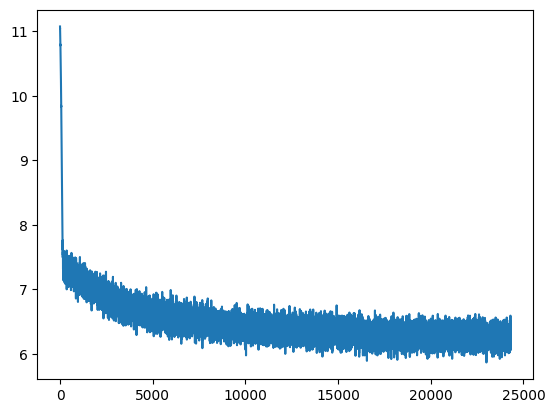

In [17]:
# hyper-params
max_epochs = 3
lr = 0.01
batch_size = 1000
L = 10
n_batches = len(target) // batch_size
if torch.cuda.is_available():
  DEVICE ="cuda:0"
else:
  DEVICE = "cpu"

# define models
cbow = CBoW(V, L).to(DEVICE)
optimizer = optim.Adam(cbow.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# training loop
monitoring_loss = []
for epoch in trange(max_epochs):
    with tqdm(total=n_batches) as tbar:
        for batch in get_batch(contexts, target, batch_size):
            x,y = batch
            x,y = x.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad()
            logits = cbow(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            monitoring_loss.append(float(loss))
            tbar.update(1)

# plot
plt.plot(monitoring_loss)

In [ ]:
class CBoW(nn.Module):
  def __init__(self, vocab_size:int, embedding_dim:int) -> None:
    super().__init__()
    self.emveddingbag = nn.Linear(vocab_size, embedding_dim, bias=False)
    self.linear = nn.Linear(embedding_dim, vocab_size)

  def forward(self, inputs:Any)->Any:
    h = self.embeddingbag(inputs) / inputs.sum(1)
    return self.linear(h)

### 類似単語検索

CBoWでは第一層目の結合重みが単語埋め込みベクトルとして利用できます．例えばこれは，以下のようなコードで取り出すことが可能です．
```python
word_embeddings = list(cbow.embeddingbag.parameters())[0].data.detach().cpu().numpy()
```

これを使って，クエリとして与えられた単語に対して，単語埋め込みベクトルのコサイン類似度が大きい順にtopn個を取り出して表示する関数を作ります．

クエリとして「インド」を渡した時に，以下のような結果を返す予定です．

```
>>> インド
アフリカ 	0.9803917407989502
ホルシュタイン 	0.9631898403167725
セルビア 	0.962059497833252
ハンガリー 	0.9611229300498962
```

In [ ]:
word_embeddings = list(cbow.embeddingbag.parameters())[0].data.detach().cpu().numpy()

In [ ]:
word_embedding = list(cbow.embeddingbag.parameters())[].data.detach().cpu().numpy()

#### 課題

学習済みのword embedding vectorsに対して，与えられたqueryにコサイン類似度を基準にして似ている単語を上位topn個表示する関数を作成せよ．

ただし，関数を実行した際の標準出力は上の説明に従うものとする．

In [ ]:
word_embeddings = list(cbow.embeddingbag.parameters())[0].data.detach().cpu().numpy()
def get_similar_words(query:str, topn:int=5,word2id = word2id, word_embeddings=word_embeddings):
  id = word2id[query]
  E = word_embeddings.T / np.linalg.norm(word_embeddings,ord=2, axis=1)
  target_vector = E[:,id]
  cossim = target_vector @ E
  sorted_index = np.argsort(cossim)[::-1][1:topn+1]
  print(f">>> {query}")
  for i in sorted_index:
    print(f"{id2word[i]} \t{cossim[i]}")



In [ ]:
torch.save(CBoW.state_dict(),"CBoW.pt")

In [ ]:
get_similar_words("ソフトウェア")
get_similar_words("インド")
get_similar_words("犬")
get_similar_words("日本")

訓練には膨大な時間がかかり，今回の例では更新回数が足りません．そのため最大epoch数などを増やして更なる実験を行なってみてください．より人間の感覚に近い類似単語検索が可能になるはずです．

作成した単語埋め込みベクトルは，うまく訓練すると意味の足し引きができることが知られています．

> ![](https://miro.medium.com/v2/resize:fit:1356/format:webp/1*5F4TXdFYwqi-BWTToQPIfg.jpeg)  
Trained Word2Vec Vectors with Semantic and Syntactic relationship  
出典: [Word2Vec Research Paper Explained](https://towardsdatascience.com/word2vec-research-paper-explained-205cb7eecc30)

```
# 例
女王 - 女 = 王
```

このような便利な特性を持つ単語埋め込みベクトルは，この論文の発表後に様々なNLP技術の中で当たり前に利用されるようになりました．例えば，通常データが少ない場合にはうまく単語の意味を訓練によって習得させることは難しいことが知られていました．これに対して，大規模な言語リソースを使って事前訓練された単語埋め込みを使えば，効率的に各々のタスクを解決するモデルを作成できます．   


> 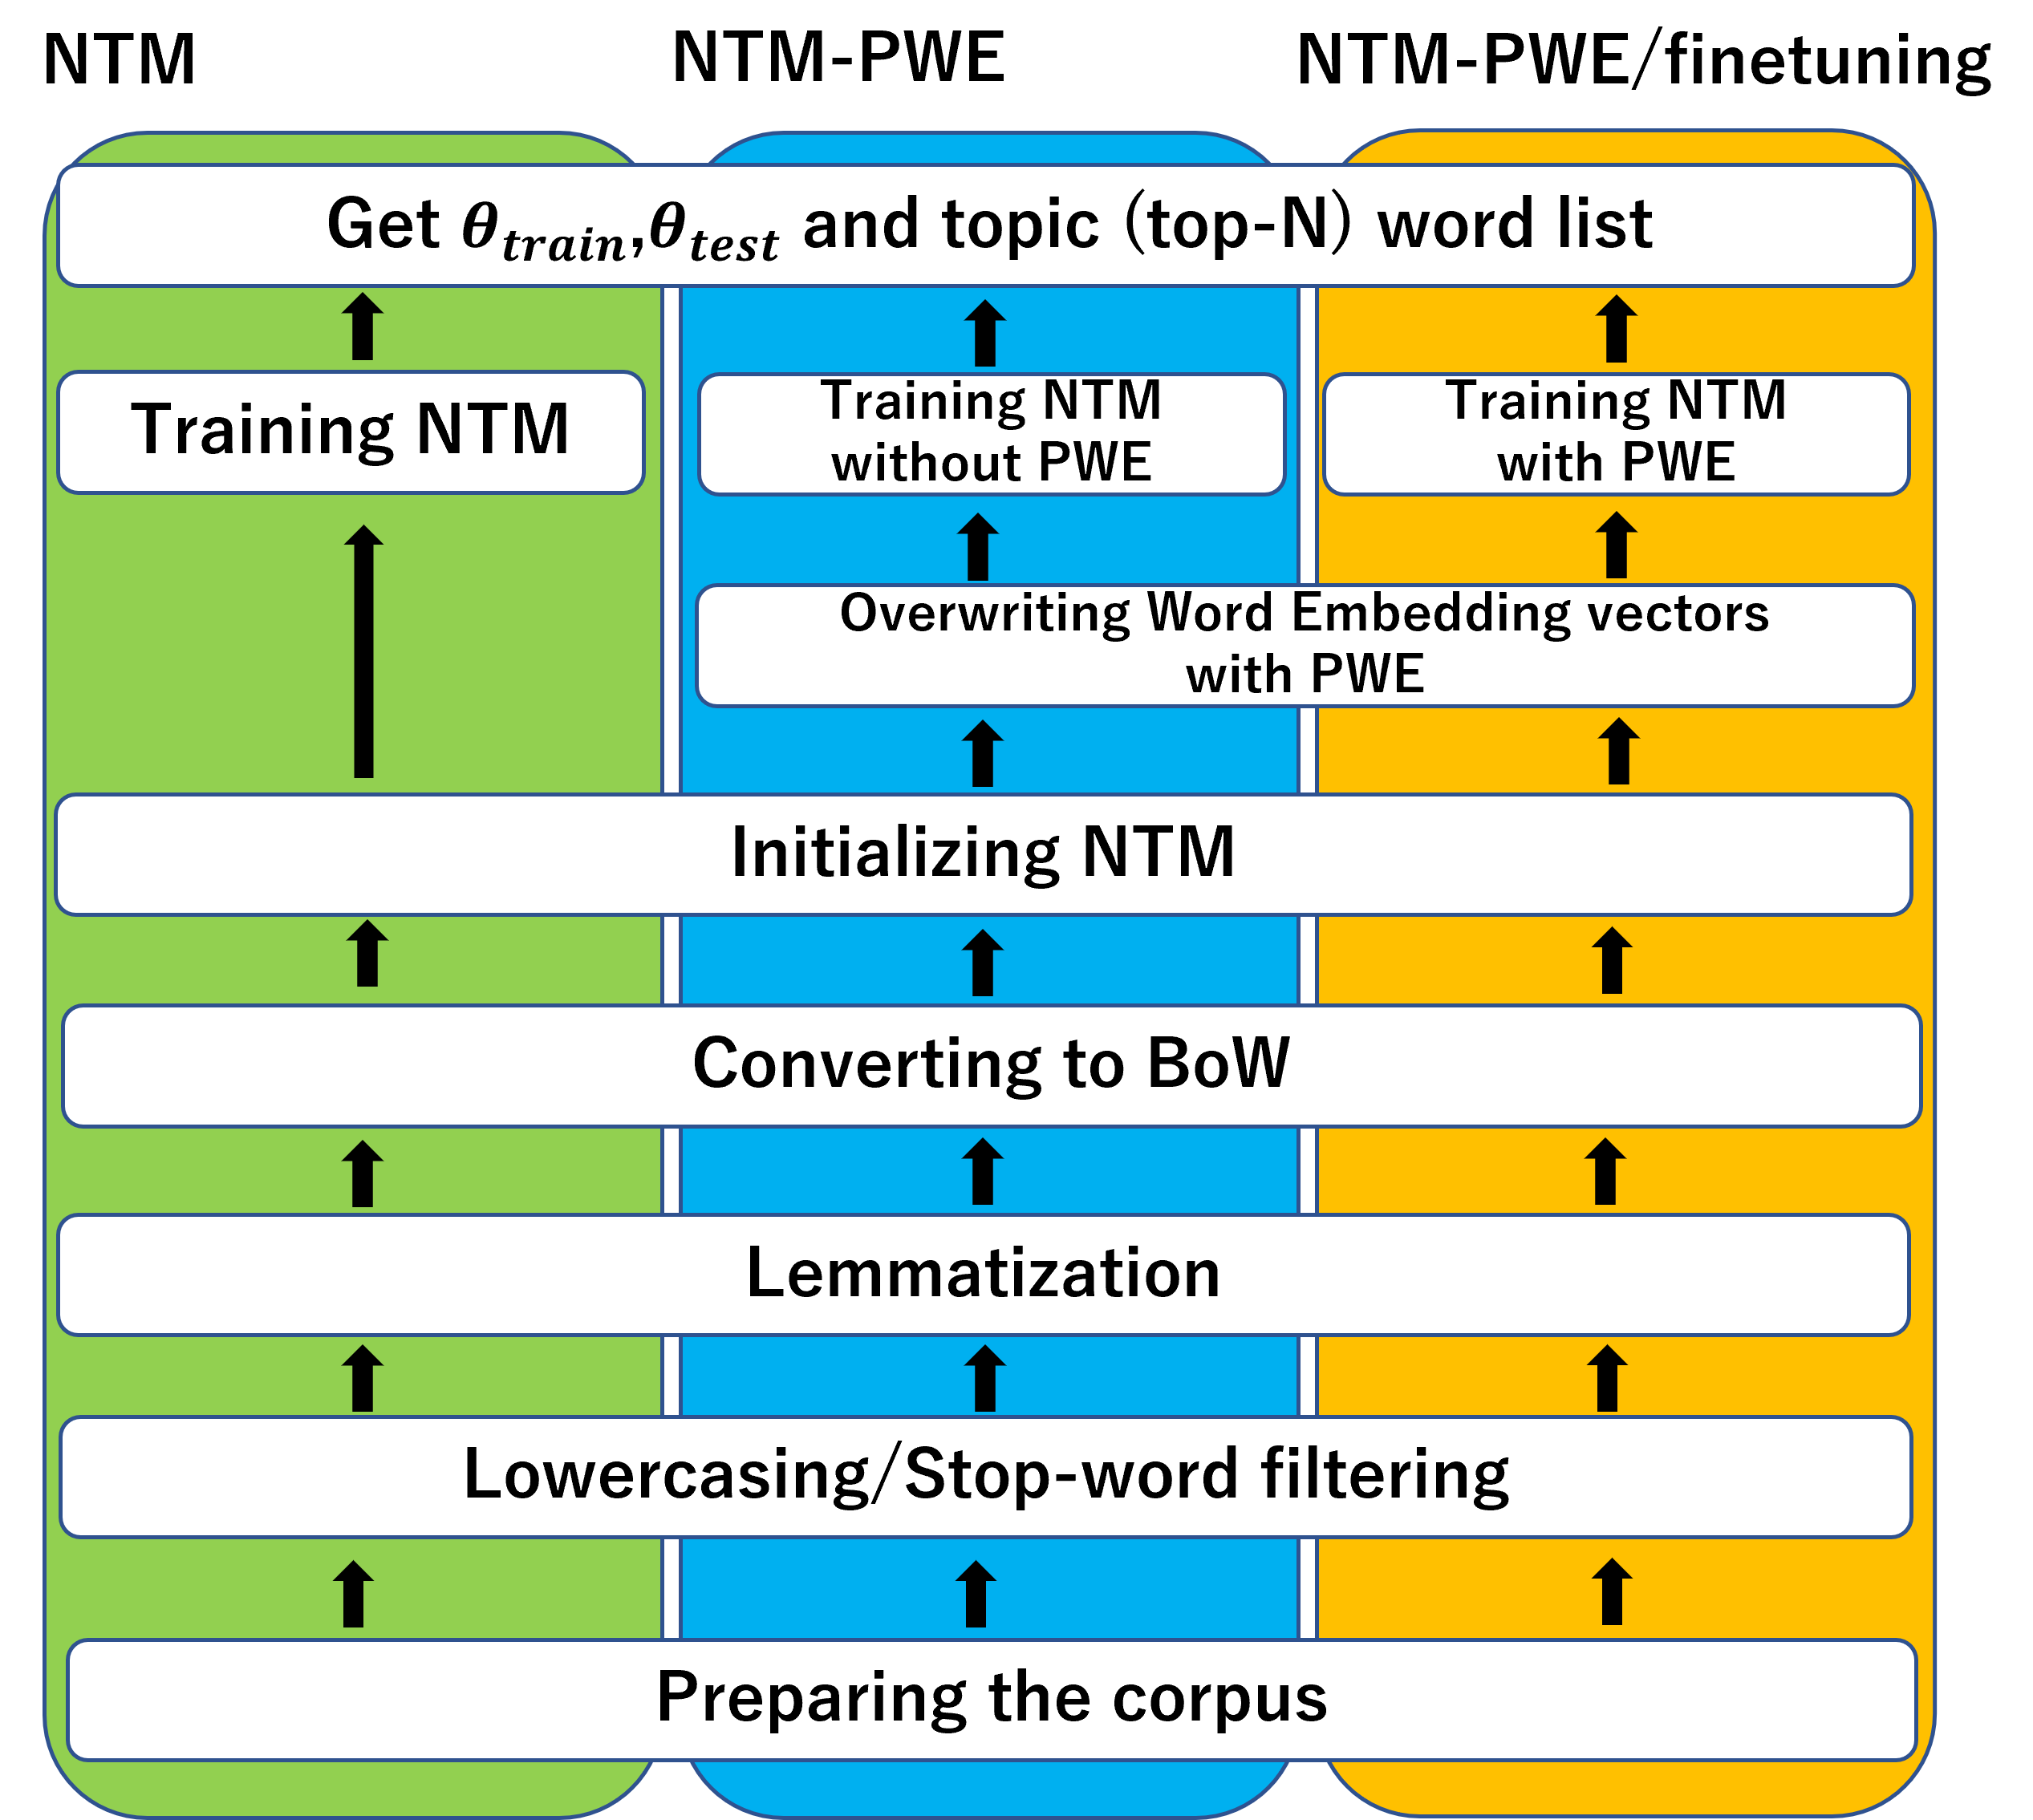  
文書中の話題抽出タスクに事前学習モデルを利用する場合のワークフロー

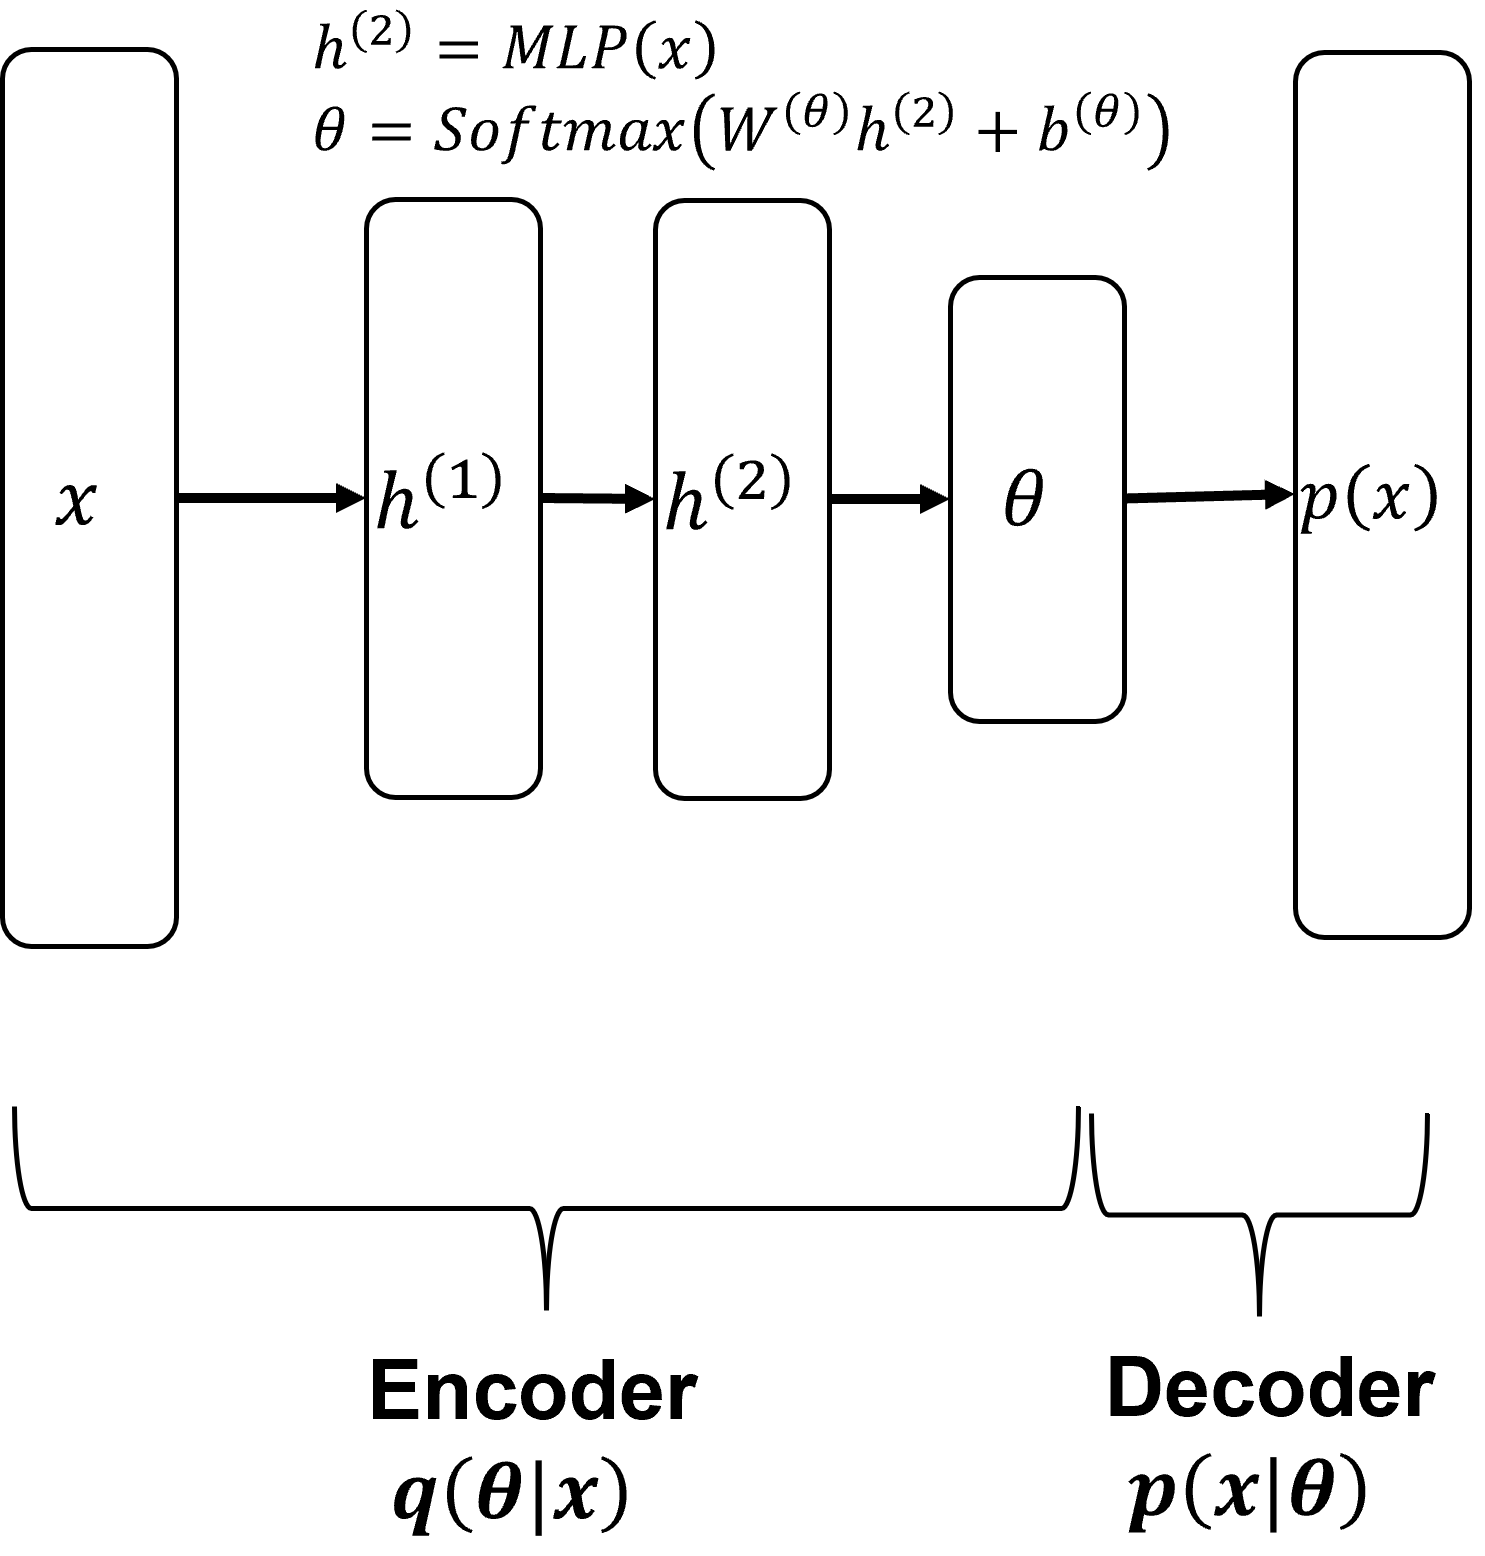
この場合だとデコーダ（図中の最終層）の結合重みの一部として学習済みの単語埋め込みベクトルを利用しています．

この事前学習済みのモデルを（pretrained model, pretrained weights）などと呼びます．事前学習済みモデルを利用するアプローチは，現在ではNLPのみならず，CV（Computer Vision）などの様々な分野で当たり前に利用されています．

## 発展課題

Skip-Gramを実装し，max_epochs=100, minibatch_size=512として訓練し，「サッカー」，「日本」，「女王」，「機械学習」について類似単語を類似度の高い順に上位5個表示するプログラムを作成せよ．

参考文献

1. [Linguistic Regularities in Continuous Space Word Representations](http://msr-waypoint.com/en-us/um/people/gzweig/Pubs/NAACL2013Regularities.pdf)
2. [Efficient estimation of word representations in vector space](http://arxiv.org/pdf/1301.3781v3.pdf)
3. [Distributed representations of words and phrases and their compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)